# REACT-Nao: Analysis in Paper

In [1]:
import json
import glob
import os
import pandas as pd
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
import seaborn as sns
from PIL import Image
import shutil




In [2]:
conditions_df = pd.read_csv("../data/react-nao_summary.csv")
conditions_df = conditions_df[['ID','Condition']]


## Functions to Read Control Log

In [29]:
def feedback_info(control_log_dict,condition,game_num):
    timestamps = {}
    
    #get counts
    up_signals = []
    new_ups = []
    up_attempts = []
    down_signals = []
    new_downs = []
    down_attempts = []
    missing_ups = 0
    missing_up_attempts = 0
    missing_downs = 0
    missing_down_attempts = 0

    last_frame = 0
    last_signal = -101
    pressing_up = False
    pressing_down = False
    
    highlight_destroy = None
    ask_before = None
    ask_after = None
    
    late_visit = None
    
    start_first = None
    end_first = None
    start_second = None
    end_second = None
    start_third = None
    end_third = None
        
    for frame in list(control_log_dict.keys()):
        timestamps[frame] = control_log_dict[frame]["frame"]["timestamp"]
        this_frame = control_log_dict[frame]["frame"]
        frame = int(frame)
        if this_frame['signal_up']==True:
            if not(pressing_up):
                new_ups.append(frame)
            up_signals.append(frame)
            pressing_up = True
            last_signal = frame
        if this_frame['signal_down']==True:
            if not(pressing_down):
                new_downs.append(frame)
            down_signals.append(frame)
            last_signal = frame
            pressing_down = True
        if this_frame['tried_signal_up']==True:
            
            up_attempts.append(frame)
            if frame-last_frame > 1 and last_frame not in up_signals and last_frame not in up_attempts and last_frame not in down_signals and last_frame not in down_attempts:
                if frame - last_signal < 100:
                    up_attempts.append(frame-1)
                    missing_up_attempts+=1
                    #print("missing up attempt")
                else:
                    up_signals.append(frame-1)
                    missing_ups+=1
                    last_signal=frame-1
                    #print("missing up")
            if not(pressing_up):
                new_ups.append(frame)
            pressing_up = True
        
                
                
        if this_frame['tried_signal_down']==True:
            
            down_attempts.append(frame)
            if frame-last_frame > 1 and last_frame not in down_signals and last_frame not in down_attempts and last_frame not in up_signals and last_frame not in up_attempts:
                if frame - last_signal < 100:
                    down_attempts.append(frame-1)
                    missing_down_attempts+=1
                    #print("missing down attempt: ",frame)
                else:
                    down_signals.append(frame-1)
                    missing_downs+=1
                    last_signal=frame-1
                    #print("missing down: ",frame)
            if not(pressing_down):
                new_downs.append(frame)
            pressing_down = True
        

        if game_num in ['3','4']:
            highlight,before,after,stage = action_from_game_state(this_frame)
            if stage == "first" and start_first == None:
                start_first = frame
            elif stage == "between12" and end_first == None:
                end_first = last_frame
            elif stage == "second" and start_second == None:
                start_second = frame
            elif stage == "between23" and end_second == None:
                end_second = last_frame
            elif stage == "third" and start_third == None:
                start_third = frame
            elif stage == "after_third" and end_third == None:
                end_third = last_frame
            
            if highlight_destroy == None and highlight:
                highlight_destroy = frame
            if ask_before == None and before and condition in ['A','B']:
                ask_before = frame
            if ask_after == None and after and condition in ['C','D']:
                ask_after = frame
        if game_num in ['5','6']:
            if len(this_frame['enemies_right_positions']) == 0 and late_visit == None:
                late_visit = frame
        last_frame = frame
        
        if not(this_frame['tried_signal_up']) and not(this_frame['signal_up']):
            pressing_up = False
        if not(this_frame['tried_signal_down']) and not(this_frame['signal_down']):
            pressing_down = False
            
    data = {'condition':condition, 'game_num':game_num, 'timestamps':timestamps,
            'first_frame':0,'last_frame':last_frame,
            
            'up_newdisplay_list':up_signals, 'up_newstart_list':new_ups, 'up_pressed_list':up_attempts,
            'down_newdisplay_list':down_signals,'down_newstart_list':new_downs,'down_pressed_list':down_attempts,
            
            'highlight_destroy':highlight_destroy,'ask_before':ask_before,'ask_after':ask_after,
            'start_first':start_first, 'end_first':end_first, 'start_second':start_second,
            'end_second':end_second, 'start_third':start_third, 'end_third':end_third,
            
            'late_visit':late_visit
           }
    return data

In [30]:
GAME_ENEMIES = 9*4*3*2 # across * row per color * color * sides
MIDDLE = 600 # middle of x axis

def action_from_game_state(game_state):
        enemies_left_positions = game_state['enemies_left_positions']
        enemies_right_positions = game_state['enemies_right_positions']
        num_left_enemies = len(enemies_left_positions)
        num_right_enemies = len(enemies_right_positions)

        total_enemies = num_left_enemies+num_right_enemies

        if total_enemies < GAME_ENEMIES*.75 and game_state['ai_position']<MIDDLE*.75:
            highlight = True
        else:
            highlight = False

        # asking for feedback before crossing to help
        if total_enemies < GAME_ENEMIES*.875:
            before = True
        else:
            before = False
        # after for feedback after crossing to help
        if total_enemies <= GAME_ENEMIES*.65 and game_state["ai_position"] > MIDDLE*1.1:
            after = True
        else:
            after = False
            
        # which stage of game
        if total_enemies > GAME_ENEMIES*.8:
            stage = "before_first"
        elif total_enemies > GAME_ENEMIES*.65: #num_left_enemies > 62:
            stage = "first"
        elif num_left_enemies > (GAME_ENEMIES/2)*(4.0/12) and num_right_enemies > (GAME_ENEMIES/2)*(3.0/12):#num_right_enemies > 50 and num_left_enemies > 45:
            stage = "between12"
        elif num_left_enemies > (GAME_ENEMIES/2)*(2.0/12) and num_right_enemies > (GAME_ENEMIES/2)*(1.5/12): #num_left_enemies > 35:
            stage = "second"
        elif num_left_enemies > (GAME_ENEMIES/2)*(1.0/12) and num_right_enemies > (GAME_ENEMIES/2)*(.5/12): #num_right_enemies > 15 and num_left_enemies > 15:
            stage = "between23"
        elif num_left_enemies > 0:
            stage = "third"
        else:
            stage = "after_third"
        return highlight,before,after,stage

## Create Dataframe

In [31]:
def get_df_stats(first_visit_df,visit_val,condition):

    df = pd.DataFrame()
    
    first_visit_df=first_visit_df.iloc[:, 1:]
    quantile_df = first_visit_df.quantile([0.25,0.5,0.75])
    
    quantile_df=quantile_df.T
    
    quantile_df=quantile_df.rename(columns={0.25: "AU_0.25", 0.5: "AU_median", 0.75: "AU_0.75"})

    df['AU_mean'] = first_visit_df.mean()
    df['AU_std'] =first_visit_df.std()
    df=df.join(quantile_df['AU_0.25'])
    df=df.join(quantile_df['AU_median'])
    df=df.join(quantile_df['AU_0.75'])
    df['AU_count'] = first_visit_df.count()
    df['AU_min'] = first_visit_df.min()
    df['AU_max'] = first_visit_df.max()
    df['game_visit'] = str(games_played[game]["game_num"])+'_'+visit_val
    df.reset_index(inplace=True)
    df=df.rename(columns={"index": "AU_name"})
    df['p_id']=file
    df['condition']=condition
    df['game_num']=games_played[game]["game_num"]
    df['visit']=visit_val
    for i in range(0,4):
        col = df.pop(df.columns[len(df.columns)-1])
        df.insert(0, col.name, col)
        
    return df


## Get Statistics for Each Robot Visit

In [34]:
from statistics import mean, stdev
all_data = {}
count = 1

game_frame_path = "../data/game_frames2/"
smoothed_features_path = "../processed_data/smoothed_facial_features/"

count=0
game_frame_folder = natsorted(os.listdir(game_frame_path))
game_frame_folder.remove('.DS_Store') if '.DS_Store' in game_frame_folder else None
games_played = {}

participant_df = pd.DataFrame()

for file in game_frame_folder:
    print(file)

    count+=1
    condition = conditions_df.loc[conditions_df['ID']==file[1:],'Condition'].values[0]
    control_log_path = f"{game_frame_path}{file}"
    
    control_log_folder = os.listdir(control_log_path)
    for game_name in control_log_folder:
        
        games_played[game_name] = {}

        game_num = game_name[-6]
    
        cl_file = f"{control_log_path}/"+game_name       

        f = open(cl_file)
        
        cl_dict = json.load(f)
        
        cl_data = feedback_info(cl_dict,condition,game_num)
        
        f.close()

        for key, value in cl_data.items():
            if key not in 'timestamps':
                if(value != None and value != []):
                    if("late_visit" in key or "frame" in key or "start" in key or "end" in key or "game_num" in key or "ask" in key or "highlight" in key):
                        if("start_list" not in key):   
                            games_played[game_name][key] = int(value)

    for game in control_log_folder:
        
        game_AU_csv_path =  smoothed_features_path+file+'/'+'smoothed_facialfeatures_'+file+"_g"+str(games_played[game]["game_num"])+".csv"
        game_AU_csv = pd.read_csv(game_AU_csv_path)       

        first_visit_sum = None
        second_visit_sum = None
        third_visit_sum = None
        full = True
        
        if("start_first" in games_played[game].keys()):
            if("end_first" in games_played[game].keys()):               
                first_visit_df = game_AU_csv.loc[(game_AU_csv['frame'] >= games_played[game]["start_first"]) & (game_AU_csv['frame'] <= games_played[game]["end_first"])]
            else:
                first_visit_df = game_AU_csv.loc[(game_AU_csv['frame'] >= games_played[game]["start_first"]) & (game_AU_csv['frame'] <= games_played[game]["last_frame"])]
                 
            df = get_df_stats(first_visit_df,"first",condition)
            participant_df = pd.concat([participant_df, df], ignore_index=True)
            first_visit_sum = first_visit_df.iloc[:, 1:].mean().sum()
            
            participant_df.loc[len(participant_df.index)] = [file,condition,games_played[game]["game_num"],"first","sum",first_visit_sum,0,0,0,0,0,0,0,str(games_played[game]["game_num"])+'_'+"first"]
                        
        if("start_second" in games_played[game].keys()):
            if("end_second" in games_played[game].keys()):
                second_visit_df = game_AU_csv.loc[(game_AU_csv['frame'] >= games_played[game]["start_second"]) & (game_AU_csv['frame'] <= games_played[game]["end_second"])]
            else:
                second_visit_df = game_AU_csv.loc[(game_AU_csv['frame'] >= games_played[game]["start_second"]) & (game_AU_csv['frame'] <= games_played[game]["last_frame"])]
                
            df = get_df_stats(second_visit_df, "second",condition)
            participant_df = pd.concat([participant_df, df], ignore_index=True)
            
            second_visit_sum = second_visit_df.iloc[:, 1:].mean().sum()
            
            participant_df.loc[len(participant_df.index)] = [file,condition,games_played[game]["game_num"],"second","sum",second_visit_sum,0,0,0,0,0,0,0,str(games_played[game]["game_num"])+'_'+"second"]
                
        if("start_third" in games_played[game].keys()):
            if("end_third" in games_played[game].keys()):
                third_visit_df = game_AU_csv.loc[(game_AU_csv['frame'] >= games_played[game]["start_third"]) & (game_AU_csv['frame'] <= games_played[game]["end_third"])]
            else:
                third_visit_df = game_AU_csv.loc[(game_AU_csv['frame'] >= games_played[game]["start_third"]) & (game_AU_csv['frame'] <= games_played[game]["last_frame"])]
                
            df = get_df_stats(third_visit_df, "third",condition)
            participant_df = pd.concat([participant_df, df], ignore_index=True)
            third_visit_sum = third_visit_df.iloc[:, 1:].mean().sum()
            
            participant_df.loc[len(participant_df.index)] = [file,condition,games_played[game]["game_num"],"third","sum",third_visit_sum,0,0,0,0,0,0,0,str(games_played[game]["game_num"])+'_'+"third"]
           
        if(games_played[game]["game_num"]==5 or games_played[game]["game_num"]==6):
            
            late_visit_sum = None
            
            
            if("late_visit" in games_played[game].keys()):
                late_visit_df = game_AU_csv.loc[(game_AU_csv['frame'] >= games_played[game]["late_visit"]) & (game_AU_csv['frame'] <= games_played[game]["last_frame"])]
                late_visit_sum = late_visit_df.iloc[:, 1:].mean().sum()
                
                df = get_df_stats(late_visit_df, "late",condition)
                participant_df = pd.concat([participant_df, df], ignore_index=True)
                
                participant_df.loc[len(participant_df.index)] = [file,condition,games_played[game]["game_num"],"late","sum",late_visit_sum,0,0,0,0,0,0,0,str(games_played[game]["game_num"])+'_'+"late"]

participant_df.to_csv("./REACT-NaoAnalysis.csv")

    
    

PP102
PP103
PP104
PP105
PP107
PP109
PP110
PP111
PP112
PP113
PP114
PP115
PP119
PP121
PP122
PP123
PP124
PP125
PP126
PP127
PP128
PP129
PP130
PP131
PP133
PP135
PP136
PP137
PP138
PP139
PP140
PP141
PP143
PP144
PP145
PP147
PP148
PP149
PP150
PP151
PP152
PP153
PP154
PP155
PP156
PP159
PP160
PP161
PP162
PP163
PP164
PP165
PP166
PP167
PP168
PP169
PP170
PP172
PP173
PP175
PP176
PP177
PP178
PP179
PP180
PP181
PP182
PP183
PP184
PP185
PP186
PP187


## Plot the Robot Visit 

In [35]:
def assign_visit(row):
    if row['game_visit'] == '3_first':
        return 1
    elif row['game_visit'] == '3_second':
        return 2
    elif row['game_visit'] == '3_third':
        return 3
    
    elif row['game_visit'] == '4_first':
        return 5
    elif row['game_visit'] == '4_second':
        return 6
    elif row['game_visit'] == '4_third':
        return 7

    elif row['game_visit'] == '5_late':
        return 9
    elif row['game_visit'] == '6_late':
        return 11
    

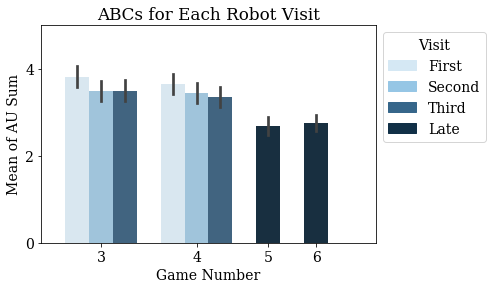

In [38]:
df = pd.read_csv("REACT-NaoAnalysis.csv")
df['visit_label_fix'] = df.apply(assign_visit,axis=1)


robotVisits = df.loc[(df['visit']=='first')|(df['visit']=='second')|(df['visit']=='third')|(df['visit']=='late')]

robotVisits = robotVisits.loc[((robotVisits['visit'].isin(['first','second','third']))&(beforeAndAfters['game_num']>2)&(robotVisits['game_num']<5))|((robotVisits['visit'] == 'late') & (robotVisits['game_num']>=5))]


robotVisits_noSums = robotVisits.loc[(robotVisits['AU_name']!='sum')]
robotVisits_Sums = robotVisits.loc[(robotVisits['AU_name']=='sum')]

###### COLORS
colors = ['white','#d5e8f4','#96C6E5','#36668a','white','#d5e8f4','#96C6E5','#36668a','white','#113047','white','#113047','white']

plt.rc('font', family='serif')
plt.rcParams["font.family"]="serif"
plt.rcParams["font.size"]=14

## ADD FAKE DATA
new_data = pd.DataFrame({'visit_label_fix': [0,4,8,10,12,20],'AU_mean': [0,0,0,0,0,0]})
robotVisits_Sums = pd.concat([new_data, robotVisits_Sums], ignore_index=True)

sns.barplot(x="visit_label_fix",y="AU_mean",data=robotVisits_Sums, errorbar="se",width=1.0,palette = colors).set(title='ABCs for Each Robot Visit')
plt.xlabel("Game Number")
plt.ylabel("Mean of AU Sum")

plt.xticks([2,6,9,11],['3','4','5','6'])

handles, labels = plt.gca().get_legend_handles_labels()
labels = [s.capitalize() for s in labels]

#specify order of items in legend
order = [1,2,3,0]

legend_colors = ['#d5e8f4','#96C6E5','#36668a','#113047']
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in legend_colors]

#add legend to plot
plt.legend(legend_handles,['First','Second','Third','Late'], title='Visit',bbox_to_anchor=(1, 1)) 

plt.yticks(np.arange(0,6,2))
plt.ylim((0,5))

plt.gcf().set_size_inches(6, 4)

plt.savefig('REACTNAO_Analysis.pdf',  bbox_inches="tight")
plt.show()
